# Firm Structure Simulator

Generate synthetic firm hierarchies with configurable selection bias.

## Features
- User-defined departments and ranks
- Configurable promotion probabilities
- Selection bias simulation
- Ground truth visualization

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## 1. Define Firm Structure

User inputs:
- Department names and number of ranks (max 10 ranks per department)
- Example: [("Law", 6), ("Engineering", 7), ("Sales", 4), ("Finance", 5)]
- Each department can have different number of ranks
- All departments can promote to CEO (highest level)

In [19]:
class FirmStructure:
    def __init__(self, departments_config):
        """
        Initialize firm structure.
        
        Args:
            departments_config: List of (dept_name, n_ranks) tuples
                Example: [("Law", 6), ("Engineering", 7), ("Sales", 4)]
        """
        self.departments_config = departments_config
        self.max_rank = max(n_ranks for _, n_ranks in departments_config)
        self.roles = self._create_roles()
        
    def _create_roles(self):
        """
        Create all roles in the firm.
        Format: {dept: [(role_name, rank_level), ...]}
        """
        roles = {}
        
        for dept, n_ranks in self.departments_config:
            dept_roles = []
            for rank in range(1, n_ranks + 1):
                role_name = f"{dept}_L{rank}"
                dept_roles.append((role_name, rank))
            roles[dept] = dept_roles
        
        # Add CEO as highest level (accessible from all departments)
        roles["Executive"] = [("CEO", self.max_rank + 1)]
        
        return roles
    
    def get_all_roles_df(self):
        """
        Return DataFrame of all roles (ground truth structure).
        """
        data = []
        for dept, role_list in self.roles.items():
            for role_name, rank in role_list:
                data.append({
                    'department': dept,
                    'role': role_name,
                    'rank': rank
                })
        return pd.DataFrame(data)
    
    def print_structure(self):
        """
        Print firm structure summary.
        """
        print("Firm Structure:")
        print("=" * 60)
        for dept, role_list in self.roles.items():
            print(f"\n{dept} ({len(role_list)} levels):")
            for role_name, rank in reversed(role_list):
                print(f"  Rank {rank}: {role_name}")

## 2. Example: Create Firm Structure

In [20]:
# User configuration
departments = [
    ("Law", 6),
    ("Engineering", 7),
    ("Sales", 4),
    ("Finance", 5)
]

firm = FirmStructure(departments)
firm.print_structure()

# Show as DataFrame
print("\n" + "=" * 60)
print("All Roles (Ground Truth):")
print("=" * 60)
roles_df = firm.get_all_roles_df()
print(roles_df)

Firm Structure:

Law (6 levels):
  Rank 6: Law_L6
  Rank 5: Law_L5
  Rank 4: Law_L4
  Rank 3: Law_L3
  Rank 2: Law_L2
  Rank 1: Law_L1

Engineering (7 levels):
  Rank 7: Engineering_L7
  Rank 6: Engineering_L6
  Rank 5: Engineering_L5
  Rank 4: Engineering_L4
  Rank 3: Engineering_L3
  Rank 2: Engineering_L2
  Rank 1: Engineering_L1

Sales (4 levels):
  Rank 4: Sales_L4
  Rank 3: Sales_L3
  Rank 2: Sales_L2
  Rank 1: Sales_L1

Finance (5 levels):
  Rank 5: Finance_L5
  Rank 4: Finance_L4
  Rank 3: Finance_L3
  Rank 2: Finance_L2
  Rank 1: Finance_L1

Executive (1 levels):
  Rank 8: CEO

All Roles (Ground Truth):
     department            role  rank
0           Law          Law_L1     1
1           Law          Law_L2     2
2           Law          Law_L3     3
3           Law          Law_L4     4
4           Law          Law_L5     5
5           Law          Law_L6     6
6   Engineering  Engineering_L1     1
7   Engineering  Engineering_L2     2
8   Engineering  Engineering_L3     3


## 3. Visualize Structure

Each department has its own vertical column.
CEO appears at the top of each department column.

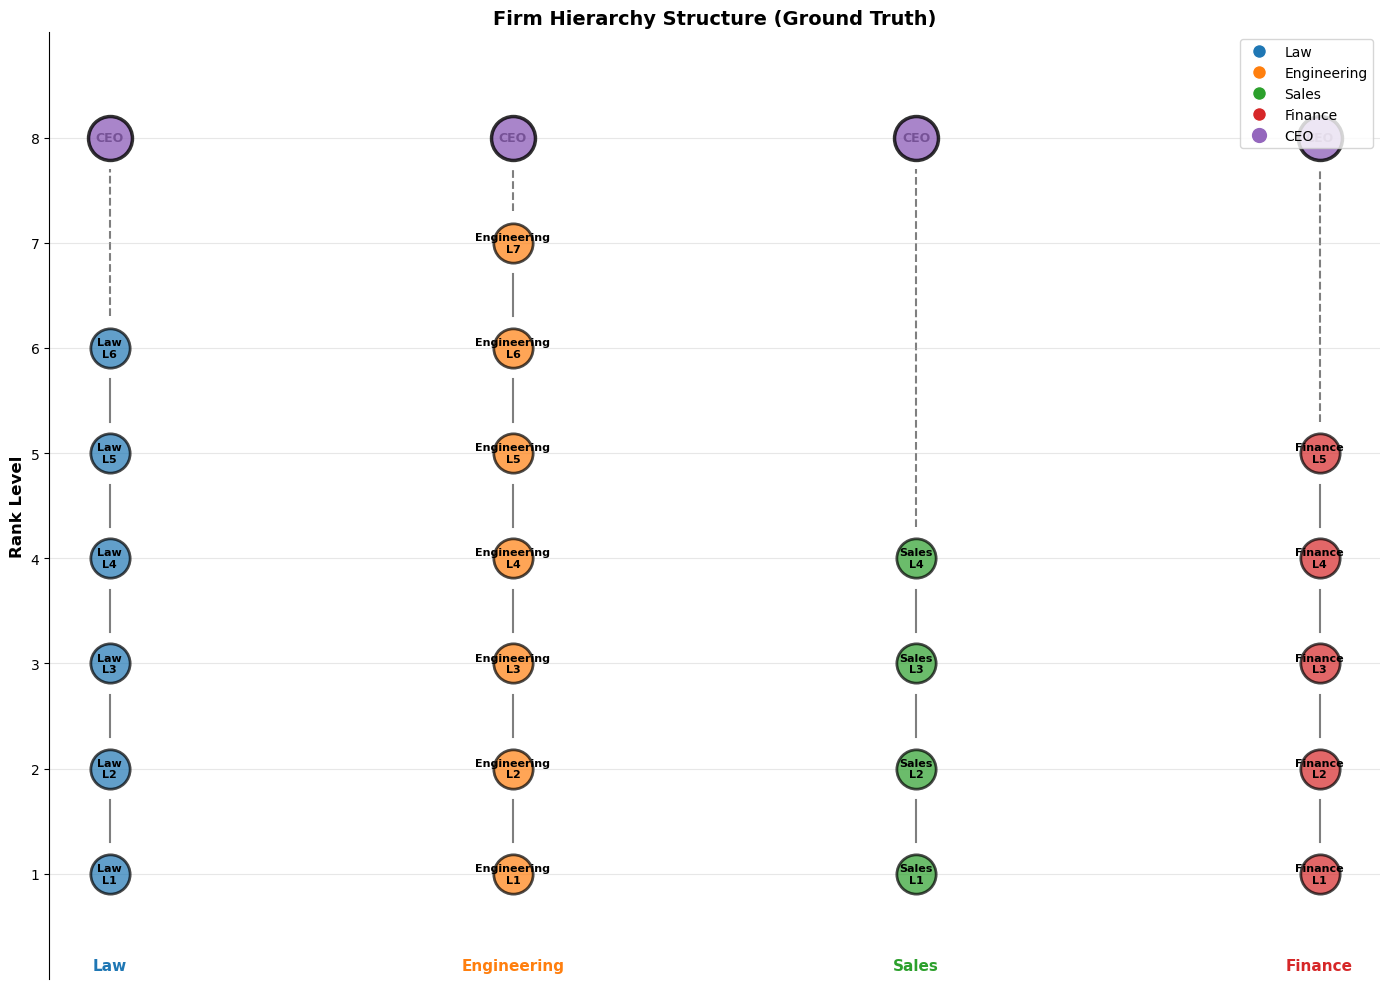

In [21]:
def visualize_structure_matplotlib(firm):
    """
    Static hierarchical visualization using matplotlib.
    Each department has its own vertical column.
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Department colors
    dept_colors = {
        'Law': '#1f77b4',
        'Engineering': '#ff7f0e',
        'Sales': '#2ca02c',
        'Finance': '#d62728',
        'Executive': '#9467bd'
    }
    
    # Assign x position to each department (excluding Executive/CEO)
    non_exec_depts = [dept for dept in firm.roles.keys() if dept != 'Executive']
    dept_x_positions = {dept: i * 3 for i, dept in enumerate(non_exec_depts)}
    
    max_rank = 0
    
    # Plot each department's roles
    for dept in non_exec_depts:
        role_list = firm.roles[dept]
        x_pos = dept_x_positions[dept]
        color = dept_colors.get(dept, 'gray')
        
        for role_name, rank in role_list:
            max_rank = max(max_rank, rank)
            y_pos = rank
            
            # Draw node
            ax.scatter(x_pos, y_pos, s=800, c=color, alpha=0.7, 
                      edgecolors='black', linewidths=2, zorder=3)
            ax.text(x_pos, y_pos, role_name.replace('_', '\n'), 
                   ha='center', va='center', fontsize=8, fontweight='bold')
            
            # Draw connecting line to next level
            if rank > 1:
                ax.plot([x_pos, x_pos], [rank - 0.3, rank - 0.7], 
                       'k-', linewidth=1.5, alpha=0.5, zorder=1)
        
        # Draw line from top rank to CEO
        top_rank = max(r for _, r in role_list)
        ceo_rank = firm.roles['Executive'][0][1]
        ax.plot([x_pos, x_pos], [top_rank + 0.3, ceo_rank - 0.3], 
               'k--', linewidth=1.5, alpha=0.5, zorder=1)
        
        # Draw CEO for this department
        ax.scatter(x_pos, ceo_rank, s=1000, c=dept_colors['Executive'], alpha=0.8, 
                  edgecolors='black', linewidths=2.5, zorder=4)
        ax.text(x_pos, ceo_rank, 'CEO', 
               ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Add department labels at bottom
    for dept, x_pos in dept_x_positions.items():
        ax.text(x_pos, 0.2, dept, ha='center', va='top', 
               fontsize=11, fontweight='bold', 
               color=dept_colors.get(dept, 'black'))
    
    # Add department legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=dept_colors.get(dept, 'gray'), 
                                  markersize=10, label=dept)
                      for dept in non_exec_depts]
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor=dept_colors['Executive'], 
                                      markersize=12, label='CEO'))
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    ax.set_ylabel('Rank Level', fontsize=12, fontweight='bold')
    ax.set_title('Firm Hierarchy Structure (Ground Truth)', fontsize=14, fontweight='bold')
    ax.set_yticks(range(1, max_rank + 2))
    ax.set_ylim(0, max_rank + 2)
    ax.grid(True, alpha=0.3, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    plt.tight_layout()
    return fig

# Show matplotlib version
fig = visualize_structure_matplotlib(firm)
plt.show()

## 4. Promotion Probability Configuration

Default: 20% promotion probability at each rank.
User can customize per department and rank.

In [22]:
class PromotionConfig:
    def __init__(self, firm_structure, default_prob=0.20):
        """
        Initialize promotion probabilities.
        
        Args:
            firm_structure: FirmStructure instance
            default_prob: Default promotion probability (0.20 = 20%)
        """
        self.firm = firm_structure
        self.default_prob = default_prob
        self.probs = self._init_default_probs()
    
    def _init_default_probs(self):
        """
        Initialize all roles with default promotion probability.
        """
        probs = {}
        for dept, role_list in self.firm.roles.items():
            for role_name, rank in role_list:
                # CEO cannot be promoted further
                if role_name == "CEO":
                    probs[role_name] = 0.0
                else:
                    probs[role_name] = self.default_prob
        return probs
    
    def set_promotion_prob(self, role_name, prob):
        """
        Set custom promotion probability for a specific role.
        """
        if role_name in self.probs:
            self.probs[role_name] = prob
        else:
            raise ValueError(f"Role {role_name} not found in firm structure")
    
    def set_department_prob(self, dept_name, prob):
        """
        Set promotion probability for all roles in a department.
        """
        if dept_name in self.firm.roles:
            for role_name, _ in self.firm.roles[dept_name]:
                if role_name != "CEO":
                    self.probs[role_name] = prob
        else:
            raise ValueError(f"Department {dept_name} not found")
    
    def get_probs_df(self):
        """
        Return DataFrame of promotion probabilities.
        """
        data = []
        for dept, role_list in self.firm.roles.items():
            for role_name, rank in role_list:
                data.append({
                    'department': dept,
                    'role': role_name,
                    'rank': rank,
                    'promotion_prob': self.probs[role_name]
                })
        return pd.DataFrame(data).sort_values(['department', 'rank'])

# Example usage
promo_config = PromotionConfig(firm, default_prob=0.20)

# Customize: Engineering has higher promotion rates
promo_config.set_department_prob("Engineering", 0.30)

# Customize: Law_L1 has lower promotion rate
promo_config.set_promotion_prob("Law_L1", 0.10)

# Show configuration
print("Promotion Probability Configuration:")
print("=" * 60)
print(promo_config.get_probs_df())

Promotion Probability Configuration:
     department            role  rank  promotion_prob
6   Engineering  Engineering_L1     1             0.3
7   Engineering  Engineering_L2     2             0.3
8   Engineering  Engineering_L3     3             0.3
9   Engineering  Engineering_L4     4             0.3
10  Engineering  Engineering_L5     5             0.3
11  Engineering  Engineering_L6     6             0.3
12  Engineering  Engineering_L7     7             0.3
22    Executive             CEO     8             0.0
17      Finance      Finance_L1     1             0.2
18      Finance      Finance_L2     2             0.2
19      Finance      Finance_L3     3             0.2
20      Finance      Finance_L4     4             0.2
21      Finance      Finance_L5     5             0.2
0           Law          Law_L1     1             0.1
1           Law          Law_L2     2             0.2
2           Law          Law_L3     3             0.2
3           Law          Law_L4     4        

## 5. Worker Trajectory Generation

Generate synthetic worker career paths.

In [23]:
class WorkerGenerator:
    def __init__(self, firm_structure, promotion_config, n_workers=500, start_year=2016, end_year=2023, seed=42):
        self.firm = firm_structure
        self.promo_config = promotion_config
        self.n_workers = n_workers
        self.start_year = start_year
        self.end_year = end_year
        random.seed(seed)
        np.random.seed(seed)
        
    def generate_trajectories(self):
        trajectories = []
        worker_id = 1
        depts = [d for d in self.firm.roles.keys() if d != 'Executive']
        
        for _ in range(self.n_workers):
            dept = random.choice(depts)
            dept_roles = self.firm.roles[dept]
            current_role, current_rank = dept_roles[0]
            
            for year in range(self.start_year, self.end_year + 1):
                trajectories.append({'worker_id': worker_id, 'year': year, 'department': dept, 'role': current_role, 'rank': current_rank})
                promo_prob = self.promo_config.probs[current_role]
                
                if random.random() < promo_prob:
                    next_rank = current_rank + 1
                    if next_rank > len(dept_roles):
                        current_role = 'CEO'
                        current_rank = self.firm.roles['Executive'][0][1]
                        dept = 'Executive'
                    else:
                        for role_name, rank in dept_roles:
                            if rank == next_rank:
                                current_role = role_name
                                current_rank = rank
                                break
            worker_id += 1
        return pd.DataFrame(trajectories)
    
    def get_summary_table(self, trajectories_df):
        avg_counts = trajectories_df.groupby(['department', 'role', 'rank']).size() / len(range(self.start_year, self.end_year + 1))
        return avg_counts.reset_index(name='avg_employees').sort_values(['department', 'rank'])

worker_gen = WorkerGenerator(firm, promo_config, n_workers=500)
trajectories = worker_gen.generate_trajectories()
print(f'Generated {len(trajectories)} records for {trajectories["worker_id"].nunique()} workers')
print(trajectories.head(10))

Generated 4000 records for 500 workers
   worker_id  year department    role  rank
0          1  2016        Law  Law_L1     1
1          1  2017        Law  Law_L2     2
2          1  2018        Law  Law_L2     2
3          1  2019        Law  Law_L2     2
4          1  2020        Law  Law_L2     2
5          1  2021        Law  Law_L2     2
6          1  2022        Law  Law_L2     2
7          1  2023        Law  Law_L3     3
8          2  2016        Law  Law_L1     1
9          2  2017        Law  Law_L2     2


## 6. Ground Truth Summary

In [24]:
summary = worker_gen.get_summary_table(trajectories)
print('Ground Truth Company (Average employees per role):')
print('=' * 60)
print(summary)

Ground Truth Company (Average employees per role):
     department            role  rank  avg_employees
0   Engineering  Engineering_L1     1         47.375
1   Engineering  Engineering_L2     2         38.500
2   Engineering  Engineering_L3     3         20.875
3   Engineering  Engineering_L4     4          8.500
4   Engineering  Engineering_L5     5          3.500
5   Engineering  Engineering_L6     6          0.250
6     Executive             CEO     8          0.625
7       Finance      Finance_L1     1         67.125
8       Finance      Finance_L2     2         38.375
9       Finance      Finance_L3     3         13.375
10      Finance      Finance_L4     4          4.375
11      Finance      Finance_L5     5          0.750
12          Law          Law_L1     1         85.000
13          Law          Law_L2     2         26.125
14          Law          Law_L3     3          6.500
15          Law          Law_L4     4          1.125
16          Law          Law_L5     5          0

## 7. Observation Bias Simulator

In [25]:
class ObservationBiasSimulator:
    def __init__(self, ground_truth_df, seed=42):
        self.ground_truth = ground_truth_df.copy()
        self.observation_rates = {}
        random.seed(seed)
        np.random.seed(seed)
        
    def set_observation_rate(self, role, rate):
        self.observation_rates[role] = rate
    
    def set_layer_based_rates(self, rates_by_rank):
        for _, row in self.ground_truth[['role', 'rank']].drop_duplicates().iterrows():
            role, rank = row['role'], row['rank']
            rate = rates_by_rank.get(rank, rates_by_rank[max(rates_by_rank.keys())])
            self.observation_rates[role] = rate
    
    def apply_bias(self):
        biased_rows = []
        for _, row in self.ground_truth.iterrows():
            if random.random() < self.observation_rates.get(row['role'], 1.0):
                biased_rows.append(row)
        return pd.DataFrame(biased_rows)
    
    def get_comparison_table(self, biased_df):
        gt_counts = self.ground_truth.groupby(['department', 'role', 'rank']).size() / len(self.ground_truth['year'].unique())
        gt_counts = gt_counts.reset_index(name='ground_truth_avg')
        
        biased_counts = biased_df.groupby(['department', 'role', 'rank']).size() / len(biased_df['year'].unique()) if len(biased_df) > 0 else pd.Series()
        biased_counts = biased_counts.reset_index(name='observed_avg')
        
        comparison = gt_counts.merge(biased_counts, on=['department', 'role', 'rank'], how='left')
        comparison['observed_avg'] = comparison['observed_avg'].fillna(0)
        comparison['observation_rate'] = comparison['role'].map(self.observation_rates)
        comparison['actual_rate'] = comparison['observed_avg'] / comparison['ground_truth_avg']
        return comparison.sort_values(['department', 'rank'])

bias_sim = ObservationBiasSimulator(trajectories)
bias_sim.set_layer_based_rates({1: 0.50, 2: 0.50, 3: 0.70, 4: 0.70, 5: 1.00, 6: 1.00, 7: 1.00, 8: 1.00})
biased_trajectories = bias_sim.apply_bias()
print(f'Ground truth: {len(trajectories)} records')
print(f'Observed: {len(biased_trajectories)} records ({len(biased_trajectories)/len(trajectories)*100:.1f}%)')

Ground truth: 4000 records
Observed: 2102 records (52.5%)


## 8. Comparison Table

In [26]:
comparison = bias_sim.get_comparison_table(biased_trajectories)
print('Comparison: Ground Truth vs Observed')
print('=' * 80)
print(comparison[['department', 'role', 'rank', 'ground_truth_avg', 'observed_avg', 'observation_rate', 'actual_rate']])

Comparison: Ground Truth vs Observed
     department            role  rank  ground_truth_avg  observed_avg  \
0   Engineering  Engineering_L1     1            47.375        25.250   
1   Engineering  Engineering_L2     2            38.500        18.875   
2   Engineering  Engineering_L3     3            20.875        14.000   
3   Engineering  Engineering_L4     4             8.500         5.500   
4   Engineering  Engineering_L5     5             3.500         3.500   
5   Engineering  Engineering_L6     6             0.250         0.250   
6     Executive             CEO     8             0.625         0.625   
7       Finance      Finance_L1     1            67.125        33.625   
8       Finance      Finance_L2     2            38.375        18.625   
9       Finance      Finance_L3     3            13.375         8.750   
10      Finance      Finance_L4     4             4.375         2.875   
11      Finance      Finance_L5     5             0.750         0.750   
12          La